In [48]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
sys.path.append('../')

import src.viz
from src.preprocessing import reconstruct_trajectory_from_angles
from src.io import load_dataframe
#sns.set(style="white", context="notebook")

from matplotlib import colormaps
from matplotlib.colors import Normalize
cmap = colormaps['bwr']

In [2]:
with open('../data/processed/embedding.pkl', "rb") as f:
        emb = pickle.load(f)

In [82]:
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(50):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)

In [83]:
phase_trajectory = list()
for points in state_trajectory:
    phase_trajectory.append(emb.pick_random_trajectory_in_cluster(points))
phase_trajectory = np.array(phase_trajectory)

In [84]:
#traj = list()
#initial_heading=0
#for trajectory in reconstructed_trajectory:
#    speed, theta = trajectory[0::2],trajectory[1::2]
#    if traj.__len__() !=0:
#        initial_pos = traj[-1][-1]
#    else:
#        initial_pos = [0,0]
#    traj.append(reconstruct_trajectory_from_angles(
#        np.array([speed,theta]).T,
#        initial_pos=initial_pos,
#        initial_heading = initial_heading)
#        )
#    initial_heading = theta[-1]
speed, theta = phase_trajectory.flatten()[0::2],phase_trajectory.flatten()[1::2]
traj = reconstruct_trajectory_from_angles(np.array([speed,theta]).T)


In [85]:
og_trajectory = load_dataframe("../data/interim/longest_trajectory.csv")
og_traj = reconstruct_trajectory_from_angles(np.array([og_trajectory['speed'],og_trajectory['curvature_angle']]).T)

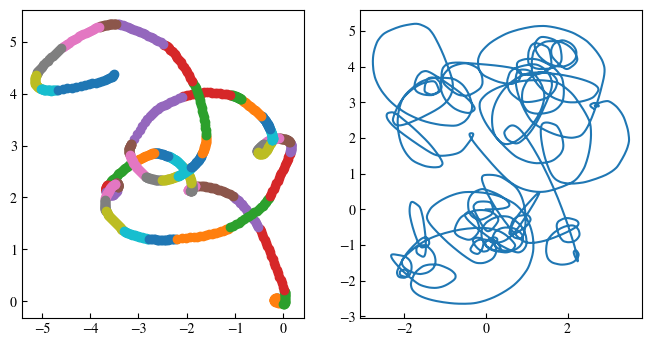

In [86]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
tint = phase_trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
for i in range(phase_trajectory.shape[0]):
    ax[0].plot(traj[i*tint:(i+1)*tint,0],traj[i*tint:(i+1)*tint,1],marker='o')
ax[1].plot(og_traj[:,0],og_traj[:,1])

## Now let us color-code the trajectories associated to the projection to the slowest eigenmode

<BarContainer object of 50 artists>

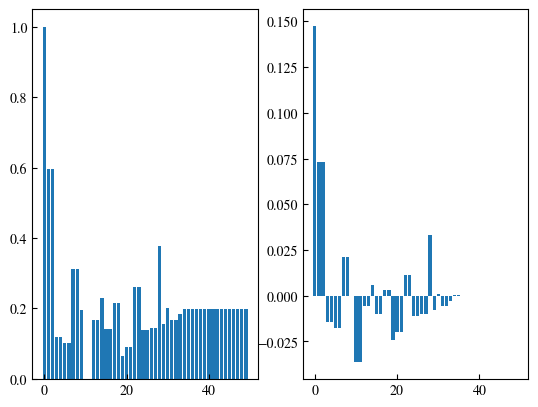

In [87]:
# find the spectrum of the stochastic matrix
eig_val,eig_vec = np.linalg.eig(emb.P)
real_spectrum = np.real(eig_val)
# sort the eigen system according to the value of the real part
eig_vec = eig_vec[np.argsort(real_spectrum)]
real_spectrum = real_spectrum[np.argsort(real_spectrum)]
slow_mode = np.real(eig_vec[-2])


norm = Normalize(vmin=np.min(slow_mode), vmax=np.max(slow_mode))
normalized_values = norm(slow_mode)  # Now in [0,1]

sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array(slow_mode)

fig,ax = plt.subplots(ncols=2)
ax[0].bar(np.arange(0,slow_mode.shape[0],1),normalized_values)
ax[1].bar(np.arange(0,slow_mode.shape[0],1),slow_mode)

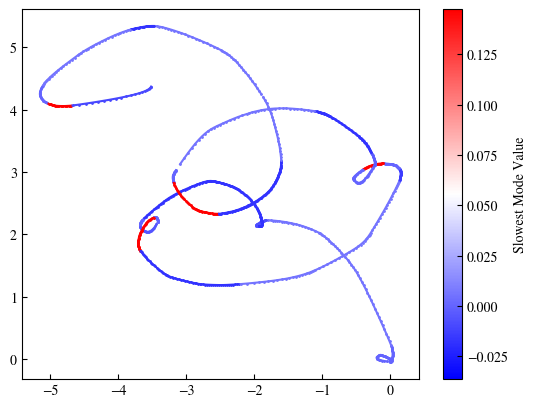

In [88]:
# Create figure and axes
fig, ax = plt.subplots()

for i in range(phase_trajectory.shape[0]):
    ax.plot(
        traj[i*tint:(i+1)*tint, 0], 
        traj[i*tint:(i+1)*tint, 1],
        marker='o',
        markersize=1,
        color=cmap(normalized_values[state_trajectory[i]])  # Use normalized values
        #color= sm.to_rgba(slow_mode[state_trajectory[i]])
    )

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array(slow_mode)
fig.colorbar(sm, ax=ax, label='Slowest Mode Value')  # Attach to `ax`
